# House Sales Analysis for House Hocket 

## 0.0 Business Problem 

House Rocket is a digital platform whose business model is the purchase and sale of properties using technology.
 
House Rocket's CEO would like to maximize the company's revenue by finding good business opportunities.

Its main strategy is to buy good houses in great locations with low prices and then resell them later at higher prices. The greater the difference between buying and selling, greater the company's profit and therefore greater is its revenue.

However, houses have many attributes that make them more or less attractive to buyers and sellers, location and time of year can also influence prices.

Therefore, your job as a Data Scientist is to answer the following questions:

- Which houses should the CEO of House Rocket buy and at what price?
- Once the house is owned by the company, when is the best time to sell it and what would be the sale price?
- Should House Rocket reform the house to increase the sale price? What would be the suggestions for changes? What is the increase in the price given for each option?


### 0.0.1 Strategy Aproach

To answer these questions, at first I will do a good exploratory analysis of the data, in order to gain insights that in addition to answering some of the questions, will help to see other points that perhaps the business team did not know before.

Later, a linear model will be adjusted to adhere to quantitative issues, such as the price increase.

The linear model was chosen because it is parametric and part of an optimization problem, allowing to observe the importance of each variable in the price increase (we can know how much, on average, the price increases for each increase in the variable unit).

### 0.1 Dataset Features 

- **id** :a notation for a house

- **date**: Date house was sold

- **price**: Price is prediction target

- **bedrooms**: Number of Bedrooms/House

- **bathrooms**: Number of bathrooms/bedrooms

- **sqft_living**: square footage of the home

- **sqft_lot**: square footage of the lot

- **floors** :Total floors (levels) in house

- **waterfront** :House which has a view to a waterfront

- **view**: Has been viewed

- **condition** :How good the condition is Overall

- **grade**: overall grade given to the housing unit, based on King County grading system

- **sqft_above** :square footage of house apart from basement

- **sqft_basement**: square footage of the basement

- **yr_built** :Built Year

- **yr_renovated** :Year when house was renovated

- **zipcode**:zip code

- **lat**: Latitude coordinate

- **long**: Longitude coordinate

- **sqft_living15** :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area

- **sqft_lot15** :lotSize area in 2015(implies-- some renovations)

In addition to this data, we will also use King County postal code data, which can be found at: [King County Open Data](https://gis-kingcounty.opendata.arcgis.com/datasets/all-zipcodes-and-po-box-as-centroids-for-king-county-zipcode-all-point)

### 0.2 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display       import Image
from IPython.core.display  import HTML

from scipy import stats
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
import statsmodels.api as sm

### 0.3 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'seaborn-pastel' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_style('whitegrid')
    
def get_summary(numerical_attributes): # A dataframe object
    
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m
        
def mode(data): # A dataframe object
    
    lst_mode = []
    lst_column = []
    
    for column in data:
        
        lst_mode.append(data[column].mode()[0])
        lst_column.append(column)
        
        d = {'Column': lst_column, 'Mode': lst_mode}
        aux = pd.DataFrame(data = d)
                
    return aux

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.4 Load Data

In [4]:
pre_df = pd.read_csv('data/kc_house_data.csv', parse_dates = ['date'])
zip_df = pd.read_csv('data/zipcodes.csv')

### 0.5 Merge Data

In [5]:
df_zip = zip_df[['ZIP', 'PREFERRED_CITY']]

In [6]:
df_zip.rename(columns = {'ZIP':'zipcode', 'PREFERRED_CITY':'city'}, inplace = True)

/home/jvbf/anaconda3/envs/house-sales/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
df = pd.merge(pre_df,df_zip,on = 'zipcode')

## 1.0 Describe Data

In [8]:
df1 = df.copy()

In [9]:
df1.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,7129300520,4060000240,4058801670,2976800796,6874200960,4268200055,3969300030,3969300030,1678400105,2172000075
date,2014-10-13 00:00:00,2014-06-23 00:00:00,2014-07-17 00:00:00,2014-09-25 00:00:00,2015-02-27 00:00:00,2015-05-01 00:00:00,2014-07-23 00:00:00,2014-12-29 00:00:00,2015-02-12 00:00:00,2014-06-23 00:00:00
price,221900.0000,205425.0000,445000.0000,236000.0000,170000.0000,245000.0000,165000.0000,239900.0000,339000.000,290900.0000
bedrooms,3,2,3,3,2,3,4,4,4,2
bathrooms,1.0000,1.0000,2.2500,1.0000,1.0000,1.7500,1.0000,1.0000,1.500,2.0000
sqft_living,1180,880,2100,1300,860,1740,1000,1000,2390,1610
sqft_lot,5650,6780,8201,5898,5265,11547,7134,7134,7480,17600
floors,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.500,2.0000
waterfront,0,0,0,0,0,0,0,0,0,0
view,0,0,2,0,0,0,0,0,2,0


In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 22669
Number of Cols: 22


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22669 entries, 0 to 22668
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             22669 non-null  int64         
 1   date           22669 non-null  datetime64[ns]
 2   price          22669 non-null  float64       
 3   bedrooms       22669 non-null  int64         
 4   bathrooms      22669 non-null  float64       
 5   sqft_living    22669 non-null  int64         
 6   sqft_lot       22669 non-null  int64         
 7   floors         22669 non-null  float64       
 8   waterfront     22669 non-null  int64         
 9   view           22669 non-null  int64         
 10  condition      22669 non-null  int64         
 11  grade          22669 non-null  int64         
 12  sqft_above     22669 non-null  int64         
 13  sqft_basement  22669 non-null  int64         
 14  yr_built       22669 non-null  int64         
 15  yr_renovated   2266

In [12]:
cons = pd.DataFrame({'colunas' : df.columns,
                    'tipo': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unicos': df.nunique()})

cons['percentual'] = round(cons['missing'] / cons['size'],2)

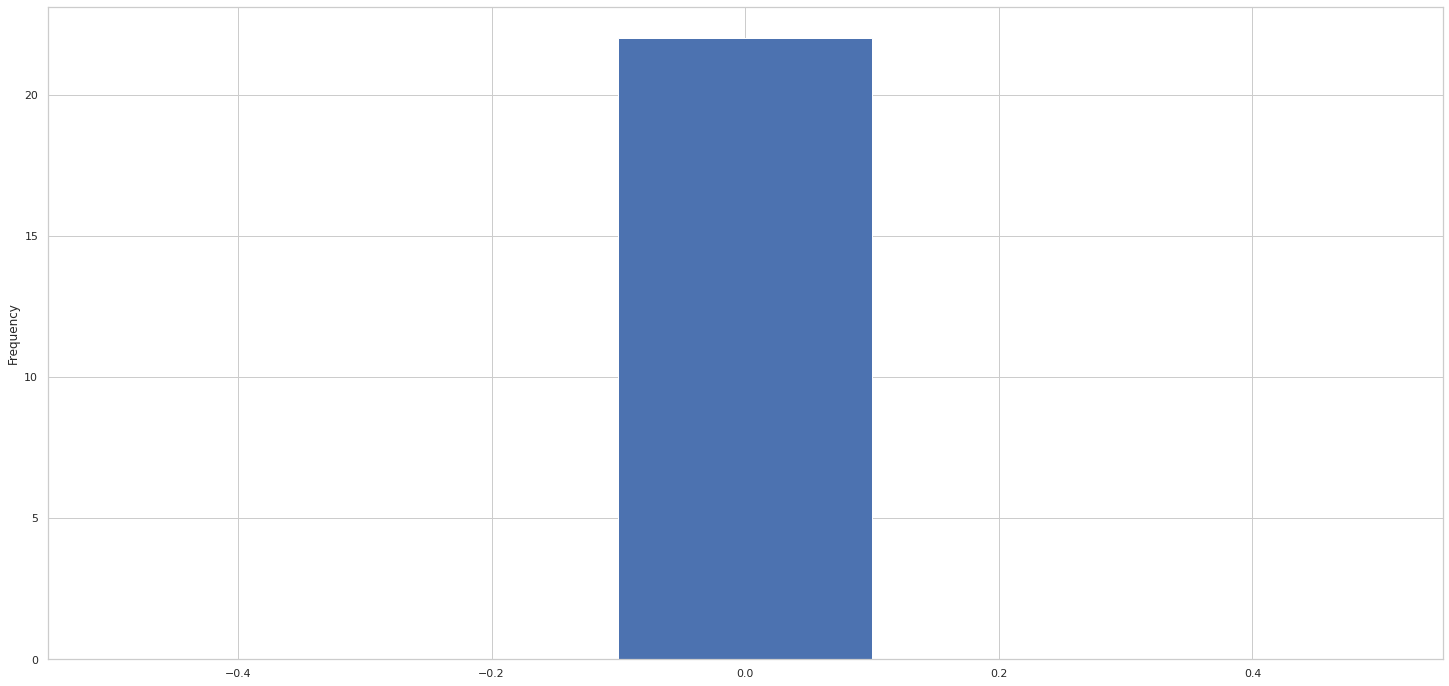

In [13]:
cons.percentual.plot.hist( bins = 5);

**There is no missing data**

In [14]:
df_aux = df1.drop(['id','date','lat','long', 'zipcode'], axis='columns')

num_attributes = df_aux.select_dtypes( include=['int64', 'float64'] )

In [15]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0,7700000.0,7625000.0,536201.260091,450000.00,362494.243969,4.024151,34.915778
1,bedrooms,0.0,33.0,33.0,3.373682,3.00,0.921593,1.936454,48.539051
2,bathrooms,0.0,8.0,8.0,2.119194,2.25,0.766044,0.494971,1.279914
3,sqft_living,290.0,13540.0,13250.0,2089.438264,1930.00,919.158330,1.453338,5.094978
4,sqft_lot,520.0,1651359.0,1650839.0,16520.716573,7708.00,45359.609179,12.513850,270.644290
5,floors,1.0,3.5,2.5,1.495236,1.50,0.537737,0.593451,-0.529538
6,waterfront,0.0,1.0,1.0,0.007190,0.00,0.084491,11.666142,134.110705
7,view,0.0,4.0,4.0,0.232785,0.00,0.763214,3.397306,10.894036
8,condition,1.0,5.0,4.0,3.409590,3.00,0.648924,1.034441,0.519031
9,grade,1.0,13.0,12.0,7.669549,7.00,1.178939,0.757885,1.152441


**Most commom values**

In [16]:
mode(num_attributes)

,Column,Mode
0,price,450000.0
1,bedrooms,3.0
2,bathrooms,2.5
3,sqft_living,1300.0
4,sqft_lot,5000.0
5,floors,1.0
6,waterfront,0.0
7,view,0.0
8,condition,3.0
9,grade,7.0


**The median house** has between 2 and 3 bathrooms, 3 bedrooms, 1 floor, and costs 450 thousand dollars with a square footage of 1300 and lot of 5000. 

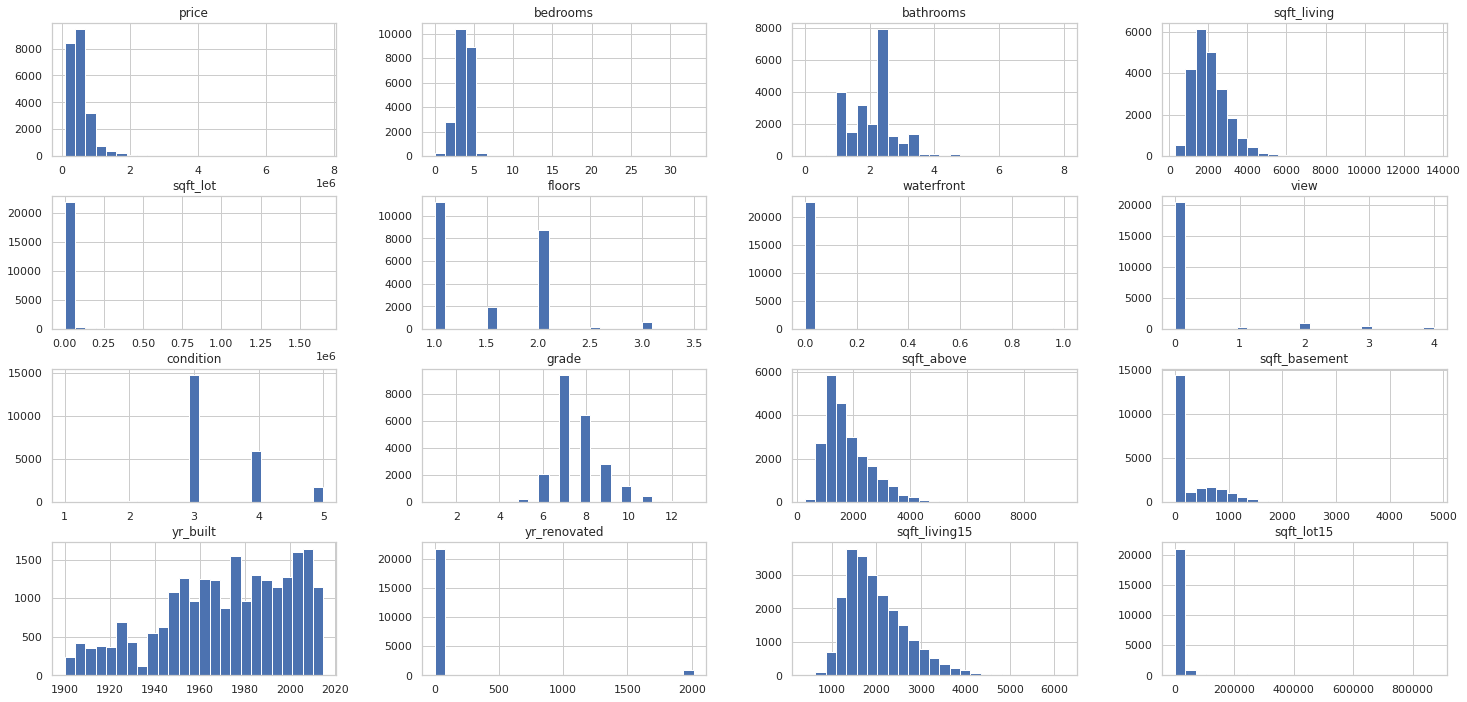

In [17]:
num_attributes.hist(bins = 25);

**Target**

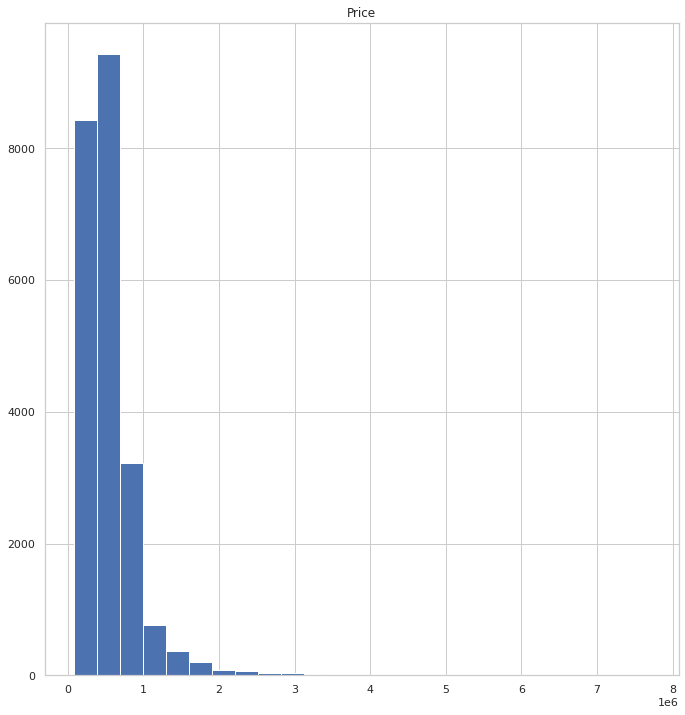

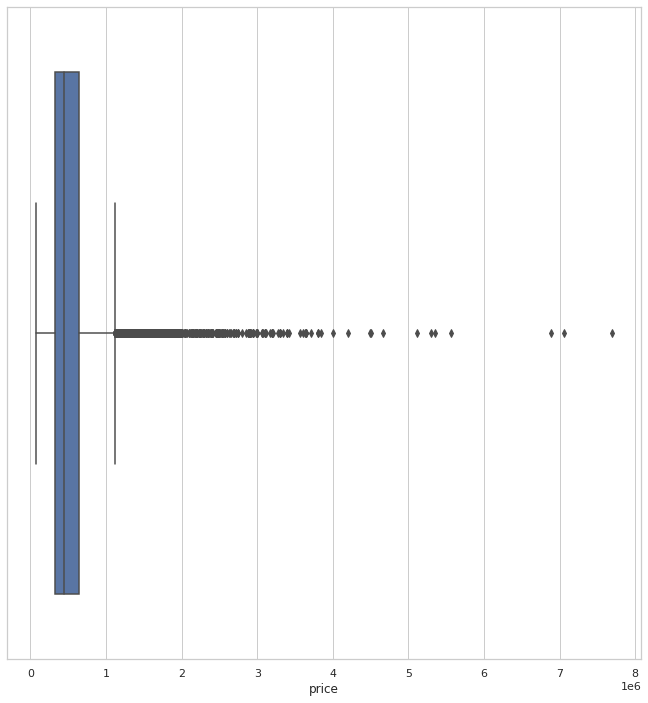

In [18]:
plt.subplot(1,2,1)
df['price'].hist(bins = 25)
plt.title('Price')
plt.show()

plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = df);

**Categorical**

In [19]:
df1['waterfront'].value_counts()

0    22506
1      163
Name: waterfront, dtype: int64

In [20]:
df1['city'].value_counts()

SEATTLE          8977
RENTON           1597
BELLEVUE         1407
AUBURN           1263
KENT             1203
REDMOND           979
KIRKLAND          977
WOODINVILLE       942
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      590
ENUMCLAW          468
SAMMAMISH         441
SAMMAMIISH        359
SNOQUALMIE        310
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            118
BLACK DIAMOND     100
FALL CITY          81
MEDINA             50
Name: city, dtype: int64

As expected, a lot of sales in **Seatle** since it is the largest city

## 2.0 Feature Engineering

In [21]:
df1 = df.copy()

### 2.1 Month and Year

In [22]:
df1['year'] = pd.DatetimeIndex(df['date']).year
df1['month'] = pd.DatetimeIndex(df['date']).month

In [23]:
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr' , 5:'Mai', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}

df1['month'] = df1['month'].map(month_dict)

### 2.2 Bathrooms and bedrooms

In order to understand better the data, we're going to create a new variable called "house_type".

This variable will work as follows:

- Houses with a bath/bed ratio greater than 1, will be labeled "robust house"
- Houses with a bath/bed ratio equal to 1, will be labeled "standard house"
- Houses with a bath/bed ratio less than 1, will be labeled "needy house"

The ideia behind this, is that we expect the bedrooms and bathrooms alone to have impact on the house price, but, maybe, a combination between these two adresses these impact more throughfully, once houses with more bathrooms than bedrooms implies in baths for guests. We'll test that assumption

We're also creating a variable called "house_ratio" witch is solely the bath/bed ratio we're going to compute

In [24]:
df1['house_ratio'] = df1['bathrooms'] / df1['bedrooms']

df1['house_type'] = df1['house_ratio'].apply(lambda x: 'robust_house' if x > 1 else 'standard house' if x == 1 else 'needy house')

In [25]:
df1['house_ratio'].describe()

count    22662.000
mean           inf
std            NaN
min          0.000
25%          0.500
50%          0.625
75%          0.750
max            inf
Name: house_ratio, dtype: float64

In [26]:
df1 = df1.replace([np.inf, -np.inf], np.nan)

In [27]:
df1 = df1.dropna()

### 2.3 Square Feet Living

We're also going to create the sqft_living_change variable, witch is the **difference between the actual sqft_living area and sqft_living15 area**

In [28]:
df1['sqft_living_change'] = df1['sqft_living'] - df1['sqft_living15']

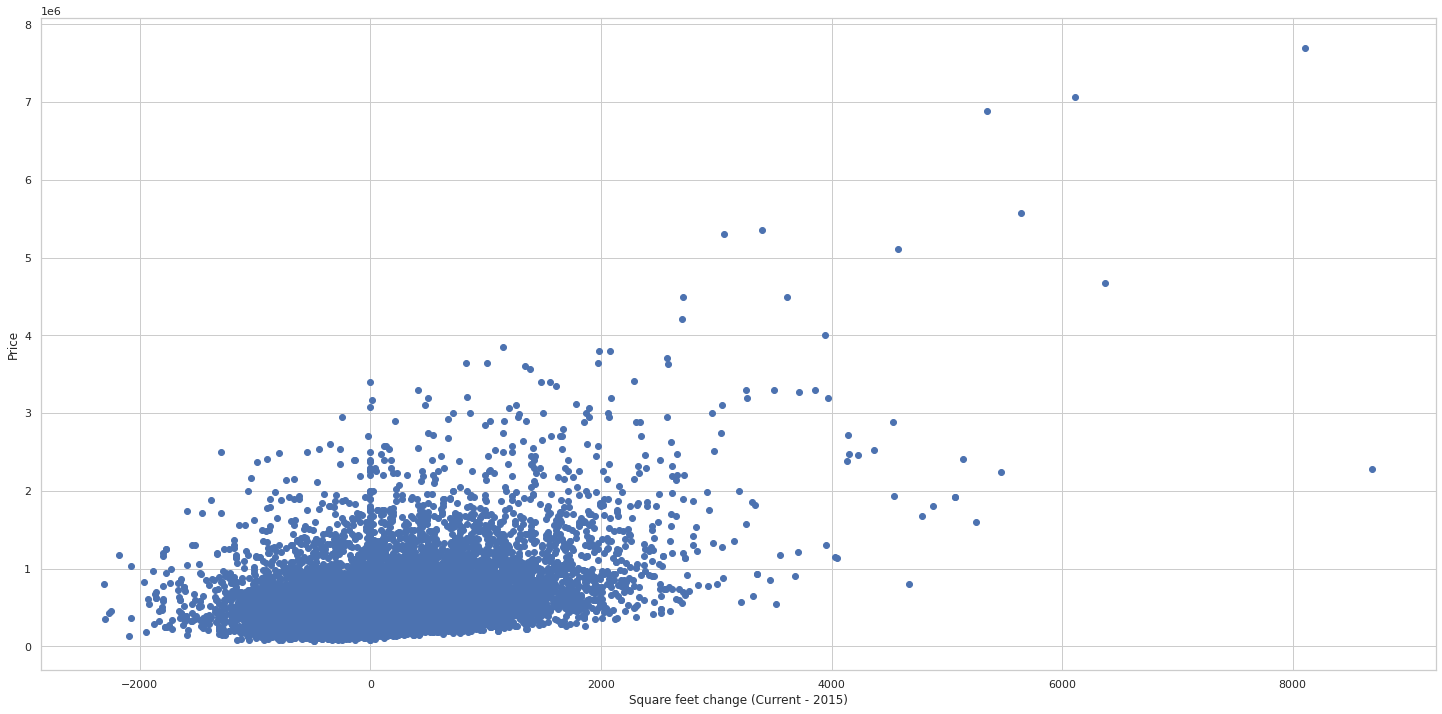

In [29]:
plt.scatter(x = 'sqft_living_change', y = 'price', data = df1)
plt.xlabel('Square feet change (Current - 2015)')
plt.ylabel('Price');

### 2.2 Basic Cleaning

In [30]:
city = []

for i in df1['city']:
    if i == 'SAMMAMIISH':
        city.append('SAMMAMISH')
    else:
        city.append(i)
    

In [31]:
df1['city'] = city

## 3.0 Exploratory Data Analysis

In [32]:
df2 = df1.copy()

### 3.1 Numerical Features

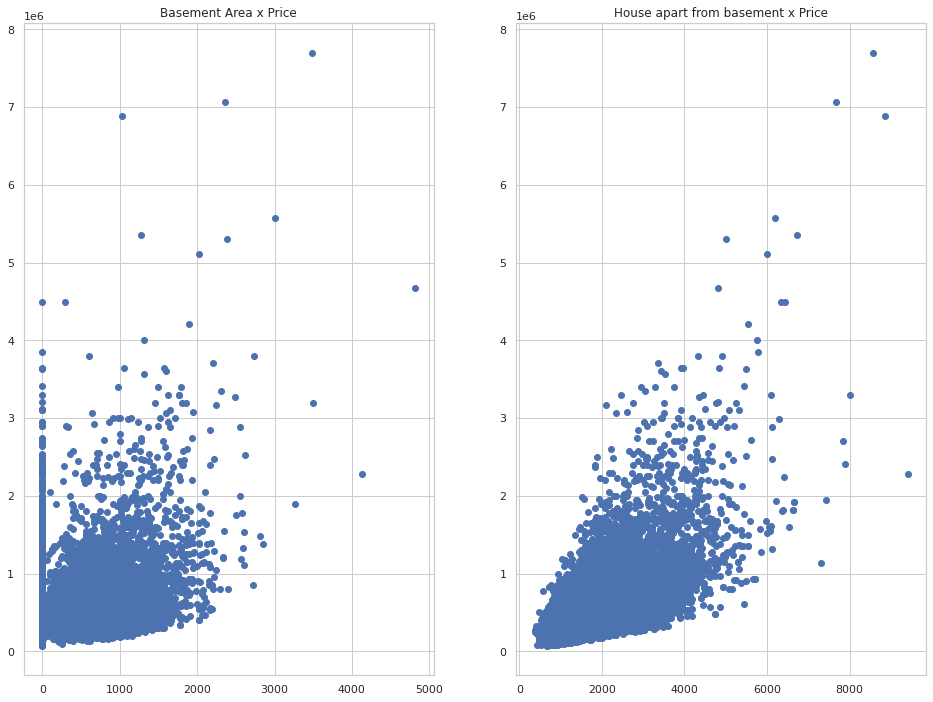

In [33]:
plt.subplot(1,3,1)
plt.scatter(x = 'sqft_basement', y = 'price', data = df2)
plt.title('Basement Area x Price')

plt.subplot(1,3,2)
plt.scatter(x = 'sqft_above', y = 'price', data = df2)
plt.title('House apart from basement x Price');

Due to **Multicolinearity** we will consider only the the square feet total area variable, instead of basement, lot and living room. These variables are part of **sqft_living** witch is the **total square footage of the home**.



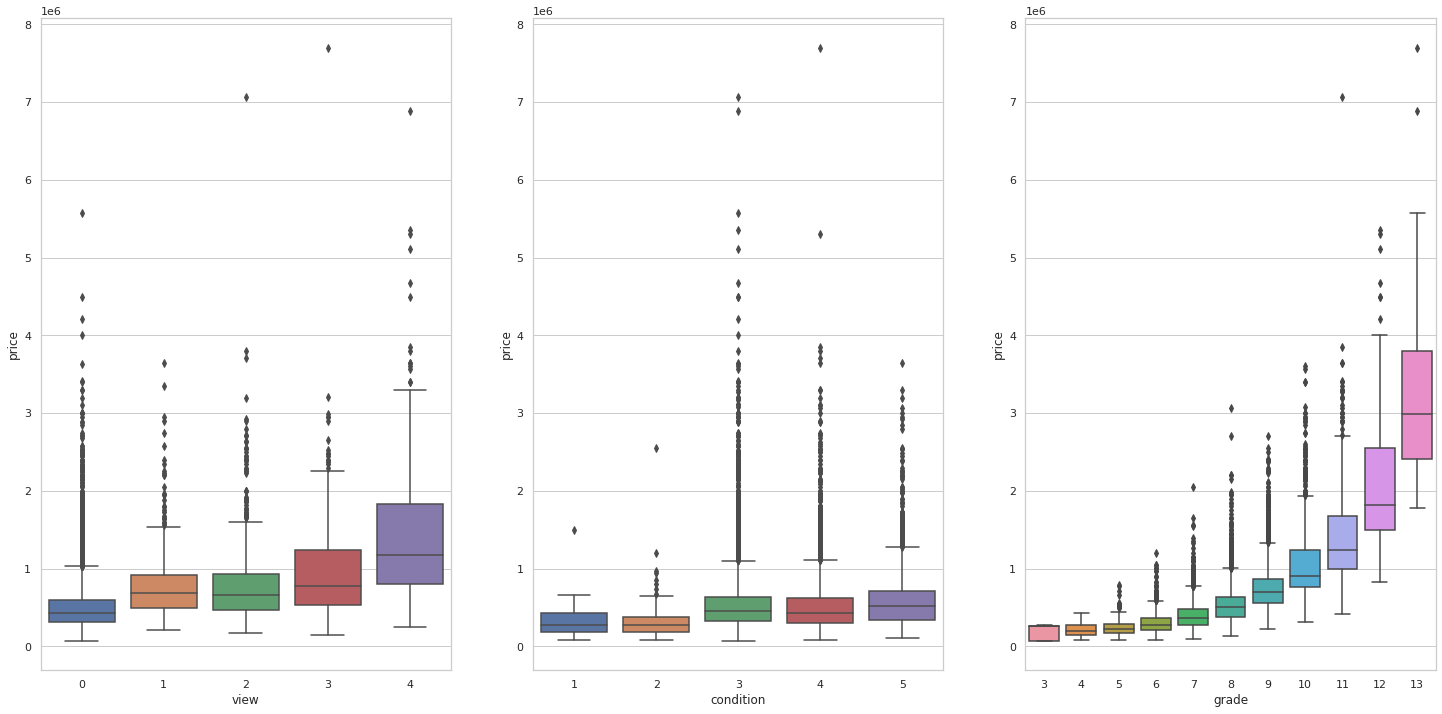

In [34]:
plt.subplot(1,3,1)
sns.boxplot(x = 'view', y = 'price', data = df2)

plt.subplot(1,3,2)
sns.boxplot(x = 'condition', y = 'price', data = df2)

plt.subplot(1,3,3)
sns.boxplot(x = 'grade', y = 'price', data = df2);

**Variação do preço por número de quartos, banheiros e andares**

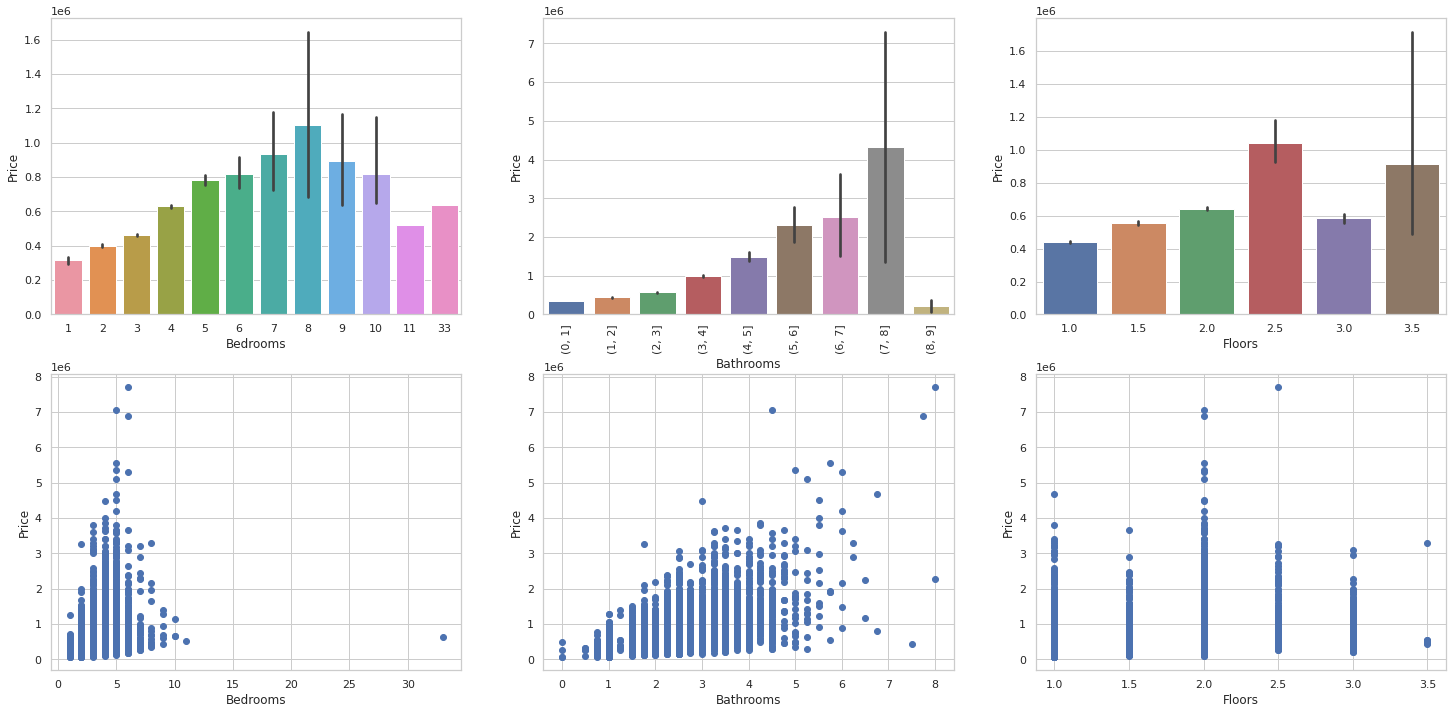

In [35]:
plt.subplot(2,3,1)
sns.barplot(x = 'bedrooms', y = 'price', data = df2)
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(2,3,2)
bins = list( np.arange( 0, 10, 1))
aux1 = df2.copy()
aux1['bathrooms_binned'] = pd.cut( df2['bathrooms'], bins = bins )
sns.barplot(x = 'bathrooms_binned', y = 'price', data = aux1)
plt.xticks( rotation=90 )
plt.xlabel('Bathrooms')
plt.ylabel('Price')


plt.subplot(2,3,3)
sns.barplot(x = 'floors', y = 'price', data = df2)
plt.xlabel('Floors')
plt.ylabel('Price')

plt.subplot(2,3,4)
plt.scatter(x = 'bedrooms', y = 'price', data = df2)
plt.xlabel('Bedrooms')
plt.ylabel('Price')

plt.subplot(2,3,5)
plt.scatter(x = 'bathrooms', y = 'price', data = df2)
plt.xlabel('Bathrooms')
plt.ylabel('Price')

plt.subplot(2,3,6)
plt.scatter(x = 'floors', y = 'price', data = df2)
plt.xlabel('Floors')
plt.ylabel('Price');

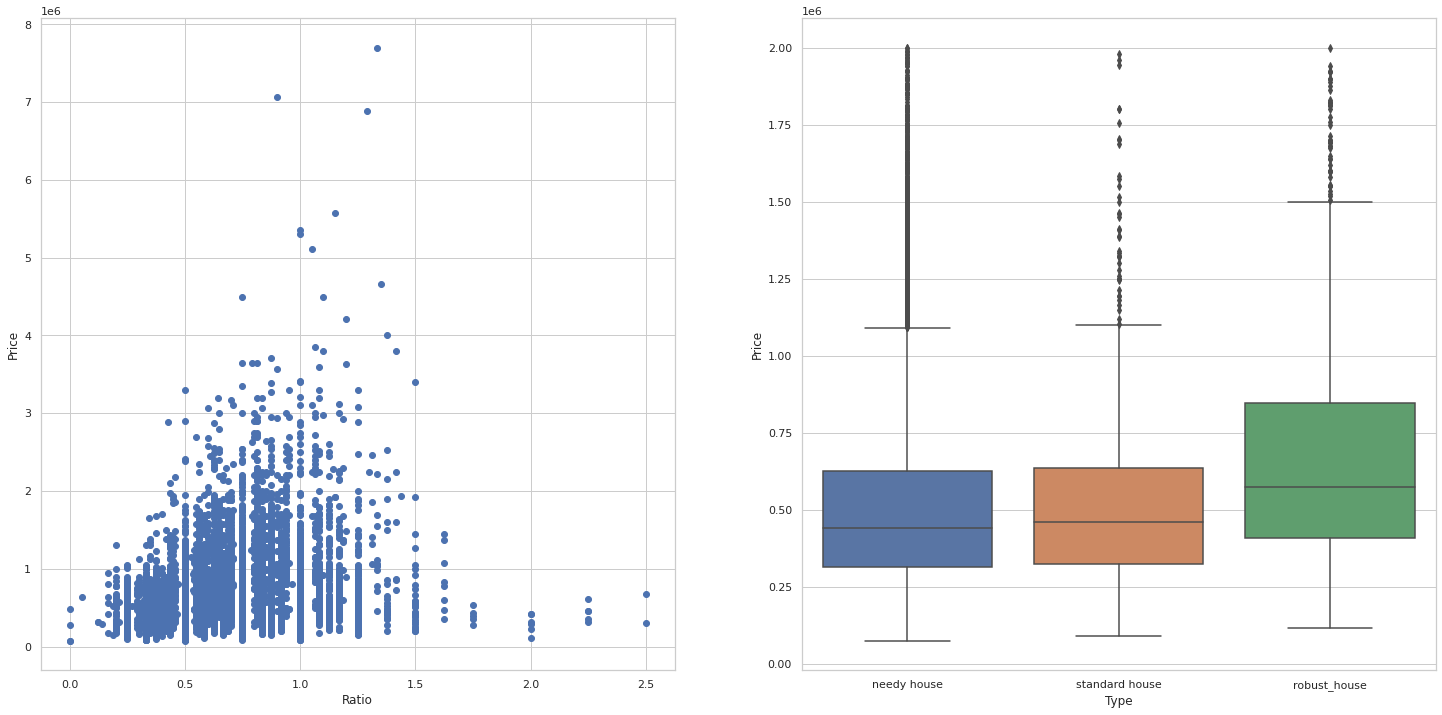

In [36]:
plt.subplot(1,2,1)
plt.scatter(x = 'house_ratio', y = 'price', data = df2)
plt.xlabel('Ratio')
plt.ylabel('Price')

plt.subplot(1,2,2)
aux1 = df2[( df2['price'] < 2000000)] # to better visualize
sns.boxplot(x = 'house_type', y = 'price', data = aux1)
plt.xlabel('Type')
plt.ylabel('Price');

The **house ratio** variable has definitely a relationship with price, but when transitioning from standard and needy houses to robust ones, this relationship seems stronger. 

In [37]:
df2['waterfront'] = df2['waterfront'].apply(lambda x: 'No' if x == 0 else 'Yes')
df2['waterfront'].value_counts()

No     22493
Yes      163
Name: waterfront, dtype: int64

**Waterfront**

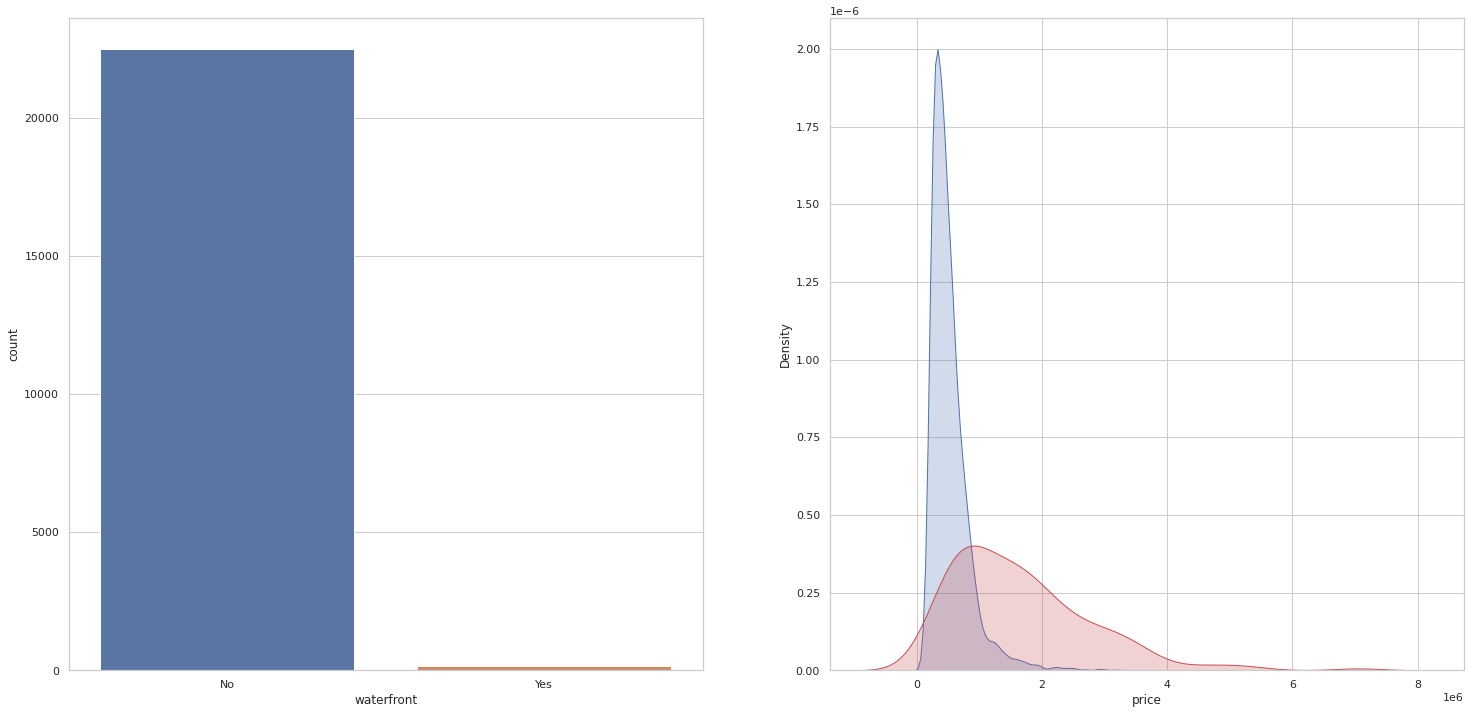

In [38]:
plt.subplot(1,2,1)
sns.countplot(x = 'waterfront', data = df2)

plt.subplot(1,2,2)
sns.kdeplot(df2[df2['waterfront']=='No']['price'],color='b',shade=True, legend = False)
sns.kdeplot(df2[df2['waterfront']=='Yes']['price'],color='r',shade=True, legend = False);

Waterfront houses are **more expensive** as expected

**Square feet living / lot** + grade / view / condition

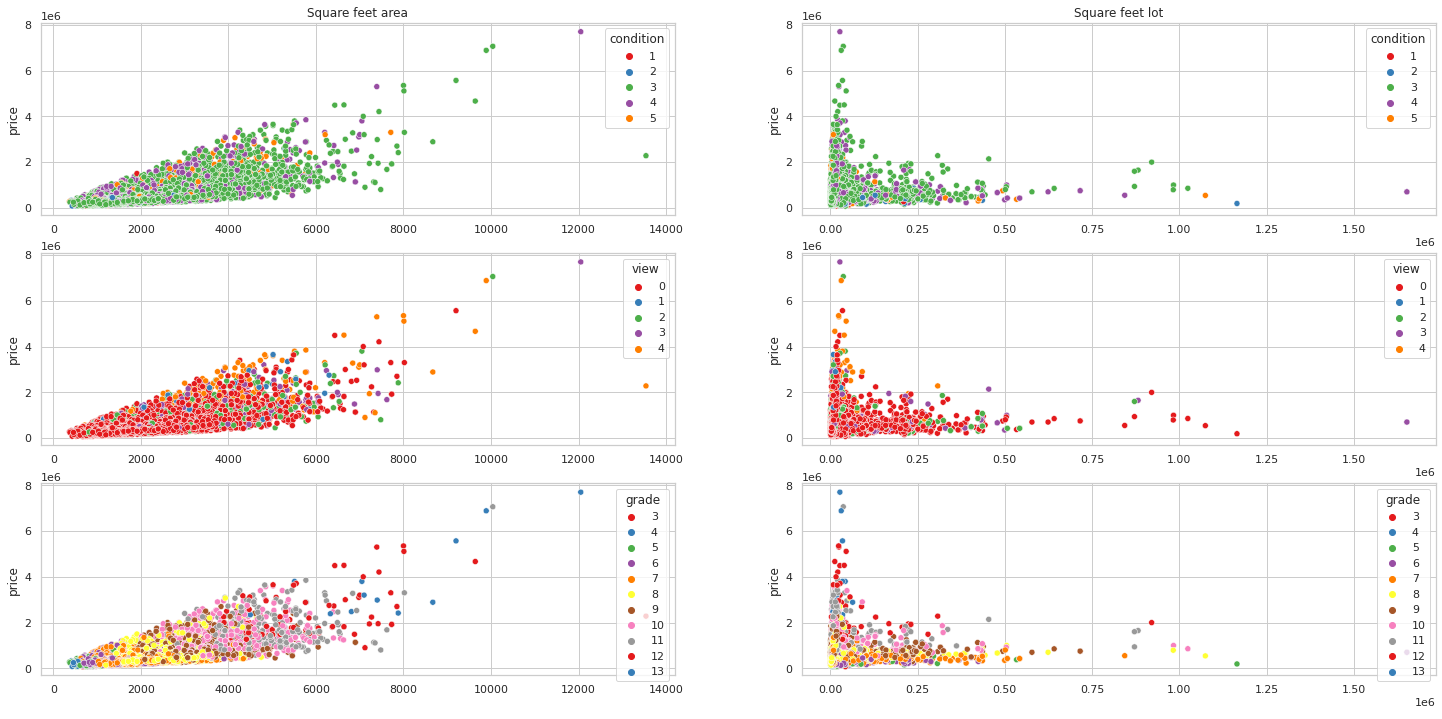

In [39]:
plt.subplot(3,2,1)
plt.title('Square feet area')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'condition', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,2)
plt.title('Square feet lot')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'condition', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,3)
plt.title(' ')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'view', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,4)
plt.title(' ')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'view', palette='Set1')
plt.xlabel(' ')

plt.subplot(3,2,5)
plt.title(' ')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2, hue = 'grade', palette='Set1')
plt.xlabel(' ')


plt.subplot(3,2,6)
plt.title(' ')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2, hue = 'grade', palette='Set1')
plt.xlabel(' ');

**square feet living area** seems to have a strong relation with price, whereas the area of the lot, doesn't

**Square feet change**

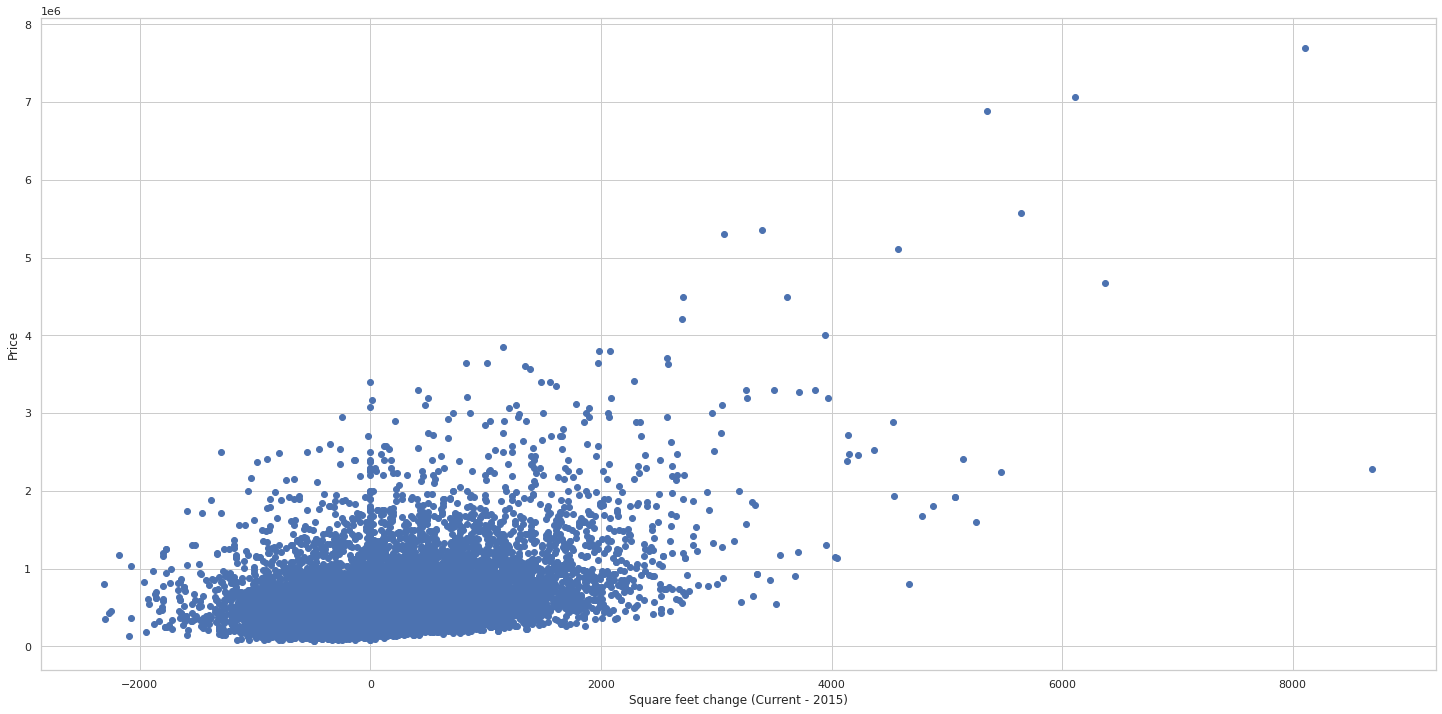

In [40]:
plt.scatter(x = 'sqft_living_change', y = 'price', data = df1)
plt.xlabel('Square feet change (Current - 2015)')
plt.ylabel('Price');

**Sales and time**

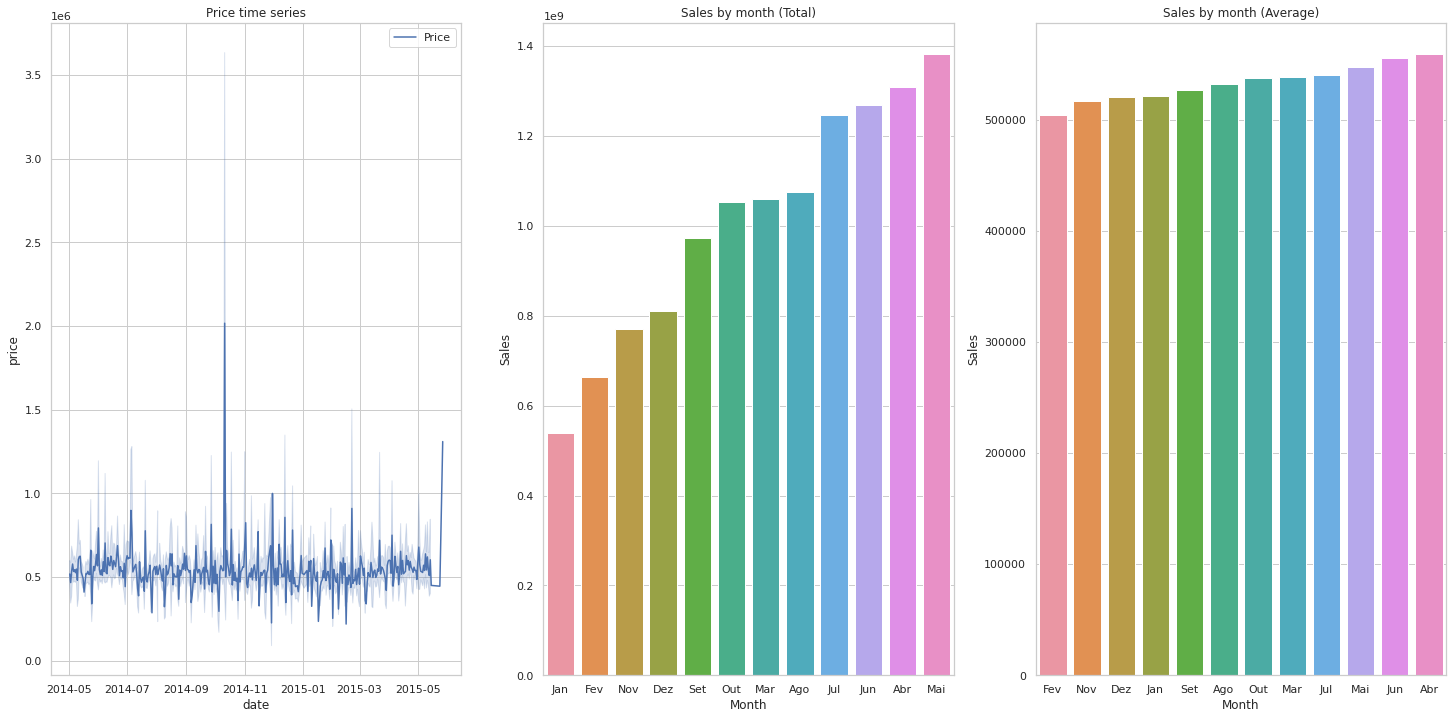

In [41]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=df2, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = df2[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data=aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = df2[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data=aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');


In retail, sales are usually heated at the end of the year, in the months of November and December. Here, we see that the real estate market deviates a little from this rule, having **higher averages in the beginning until the middle of the year, specially in April, May, June and July.**

In [42]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
0,Abr,558897.250534
6,Jun,555339.725482
7,Mai,547393.763564
5,Jul,539937.047248
8,Mar,538439.869477
10,Out,537222.659867
1,Ago,531655.367953
11,Set,526317.120130
4,Jan,521003.038685
2,Dez,520646.304627


Some months sell less, but more expensive houses, which, on average, mean that each month they have an approximate sales volume, around 500 thousand per house. However, **we will split the dataset between high and low prices** trying to understand which month sells more expensive or cheaper houses

In [43]:
df2['price'].describe()

count    2.265600e+04
mean     5.362740e+05
std      3.624995e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

We see that the median price is 450 thousand dollars, a value that divides the set of data ordered by the price in half.

- 25% of the highest values are greater than 640 thousand dollars> **this will be the set of 'high prices'**
- 25% of the lowest values are less than 322 thousand dollars> **this will be the set of 'low prices'**

In [44]:
aux_high_price = df2[df2['price'] >= 640000] 
aux_high_price['price'].describe()

count    5.687000e+03
mean     9.755728e+05
std      4.680965e+05
min      6.400000e+05
25%      7.163125e+05
50%      8.220000e+05
75%      1.032445e+06
max      7.700000e+06
Name: price, dtype: float64

In [45]:
aux_low_price = df2[df2['price'] < 322000] 
aux_low_price['price'].describe()

count      5752.000000
mean     251718.606572
std       48035.915304
min       75000.000000
25%      220000.000000
50%      259000.000000
75%      290000.000000
max      321950.000000
Name: price, dtype: float64

**High Prices**

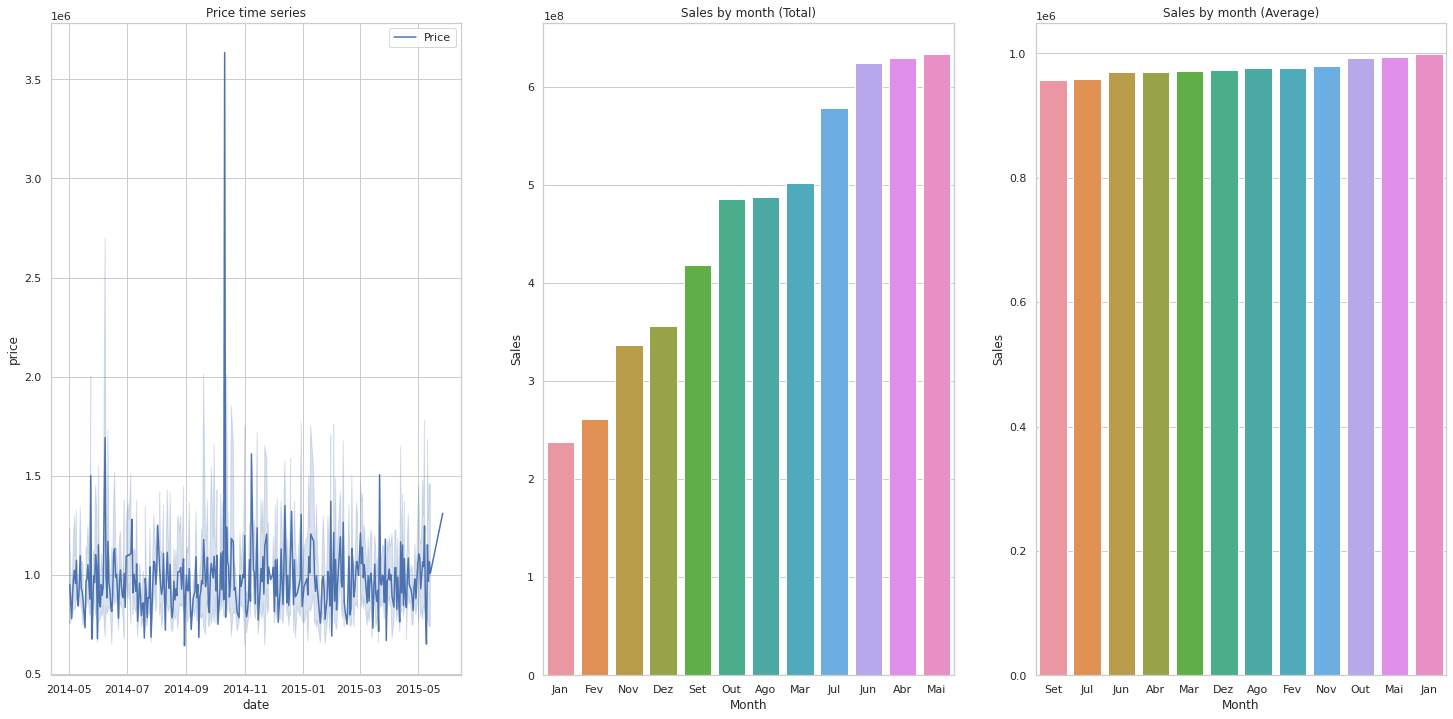

In [46]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=aux_high_price, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = aux_high_price[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data = aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = aux_high_price[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data = aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

In [47]:
aux3.rename(columns = {'month':'Month', 'price':'Average'}, inplace = True)
aux3.sort_values(by = ['Average'], ascending = False)

,Month,Average
4,Jan,999088.831933
7,Mai,993905.014129
10,Out,993019.560327
9,Nov,980574.658892
3,Fev,976287.268657
1,Ago,975916.955912
2,Dez,973817.418033
8,Mar,971431.124031
0,Abr,970593.788580
6,Jun,970207.629860


January has the lowest number of houses sold, however, the second highest average sale considering the most expensive houses. Therefore, **Mostly January**, but also February and November behave similarly.

**Low Price**

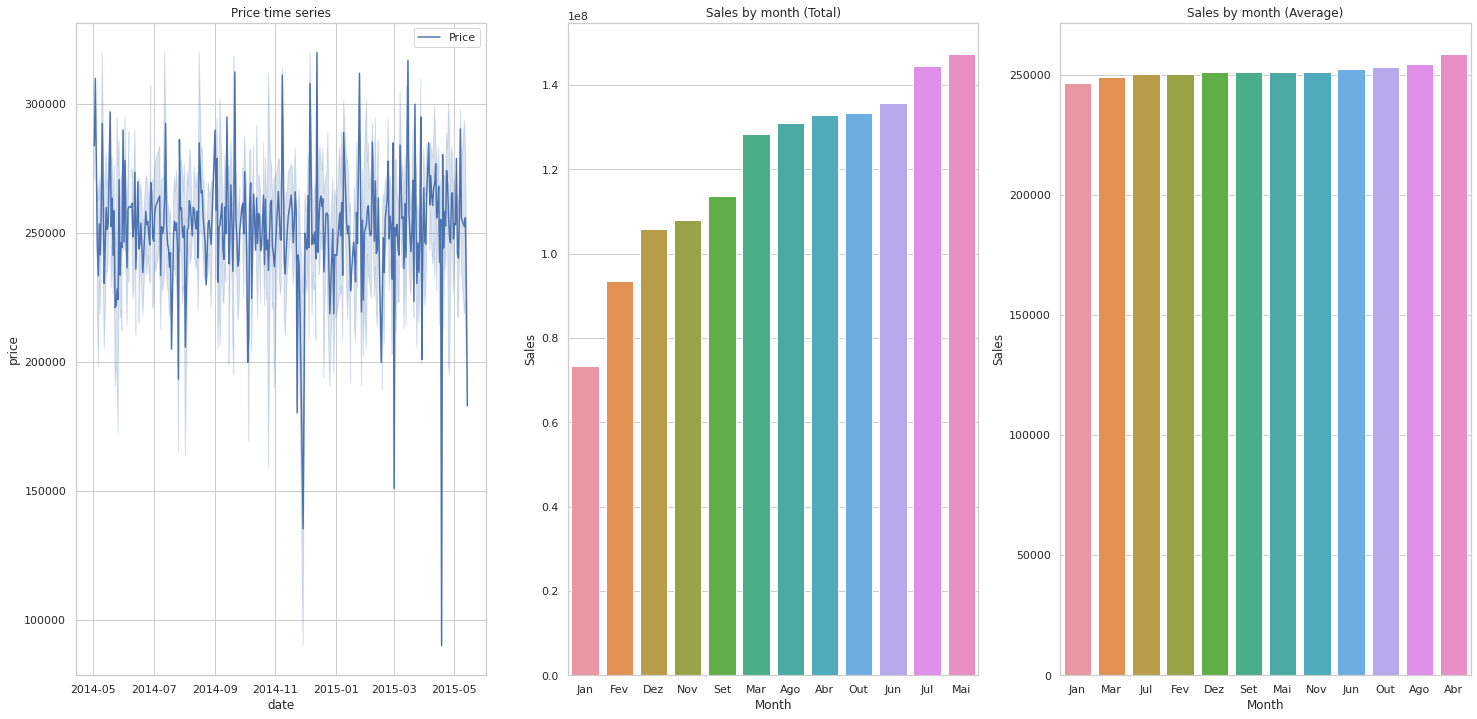

In [48]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=aux_low_price, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = aux_low_price[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data = aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = aux_low_price[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data = aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

In [49]:
aux3.rename(columns = {'month':'Month', 'price':'Average'}, inplace = True)
aux3.sort_values(by = ['Average'], ascending = False)

,Month,Average
0,Abr,258548.188716
1,Ago,254327.405825
10,Out,253257.751423
6,Jun,252121.786245
9,Nov,251042.025581
7,Mai,251010.848382
11,Set,250934.339956
2,Dez,250879.810427
3,Fev,250128.328877
5,Jul,250102.266436


**October, August and April** sell the most low price houses. As we should expect, **January** sell less of these houses

### 3.2 Location 

As mentioned before, with the zipcode, we were able to gather data from cities, and merge to the existing dataframe. Doing that, now we are able to see **sellings across the cities**. 

In [50]:
df2['city'].value_counts()

SEATTLE          8973
RENTON           1597
BELLEVUE         1407
AUBURN           1262
KENT             1201
REDMOND           978
KIRKLAND          977
WOODINVILLE       942
SAMMAMISH         800
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      589
ENUMCLAW          468
SNOQUALMIE        308
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            117
BLACK DIAMOND     100
FALL CITY          80
MEDINA             50
Name: city, dtype: int64

**Total Sales / Average Sales by City**

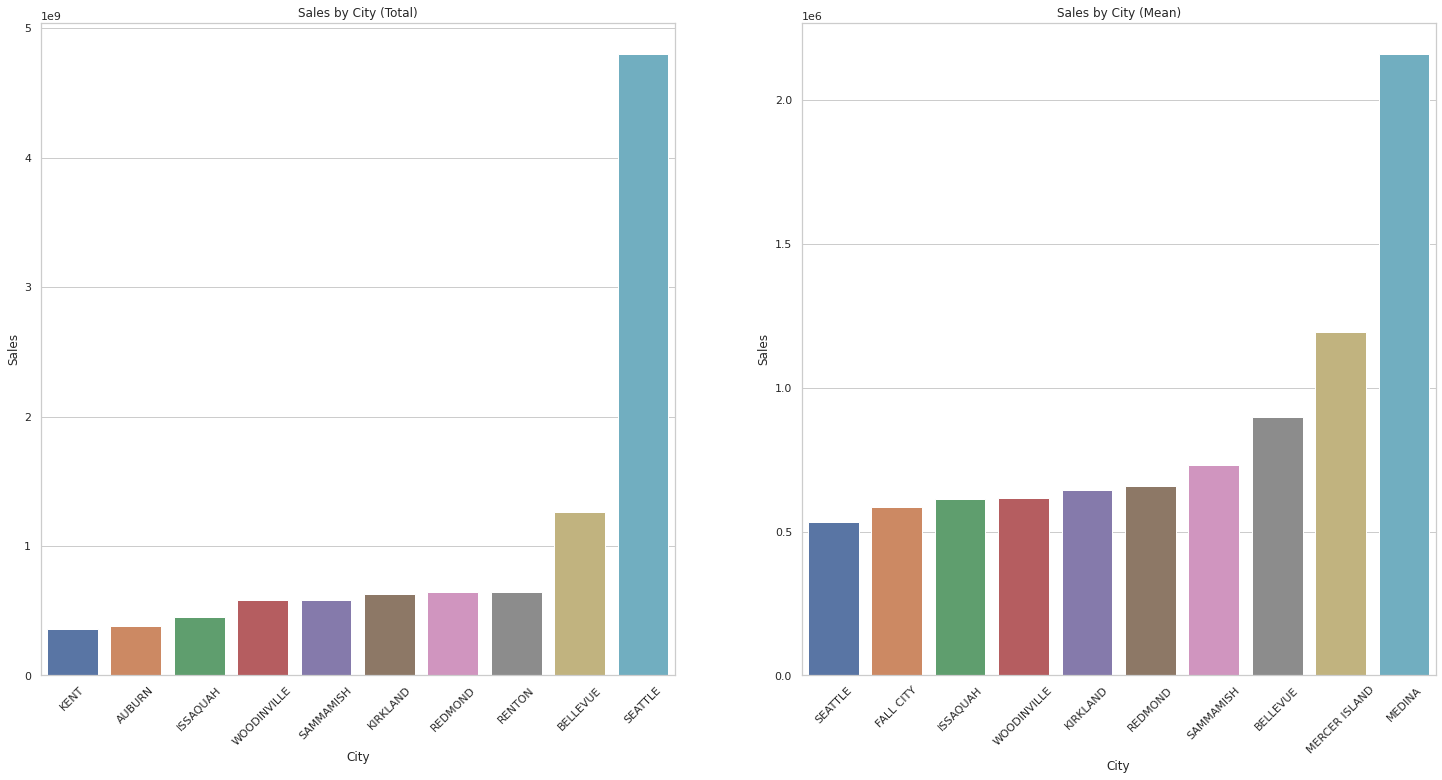

In [51]:
plt.subplot(1,2,1)
aux4 = df2[['price', 'city']].groupby('city').sum().reset_index()
sns.barplot( x='city', y='price', data= aux4.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Total)');

plt.subplot(1,2,2)
aux5 = df2[['price', 'city']].groupby('city').mean().reset_index()
sns.barplot( x='city', y='price', data= aux5.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Mean)');

In [52]:
aux5.rename(columns = {'city':'City', 'price':'Average'}, inplace = True)
aux5.sort_values(by = ['Average'], ascending = False)

,City,Average
14,MEDINA,2.160607e+06
15,MERCER ISLAND,1.194230e+06
1,BELLEVUE,8.981876e+05
19,SAMMAMISH,7.327115e+05
17,REDMOND,6.582037e+05
12,KIRKLAND,6.463742e+05
23,WOODINVILLE,6.173845e+05
9,ISSAQUAH,6.150913e+05
7,FALL CITY,5.860084e+05
20,SEATTLE,5.349804e+05


### 3.3 Multivariate Analysis

**Heatmap**

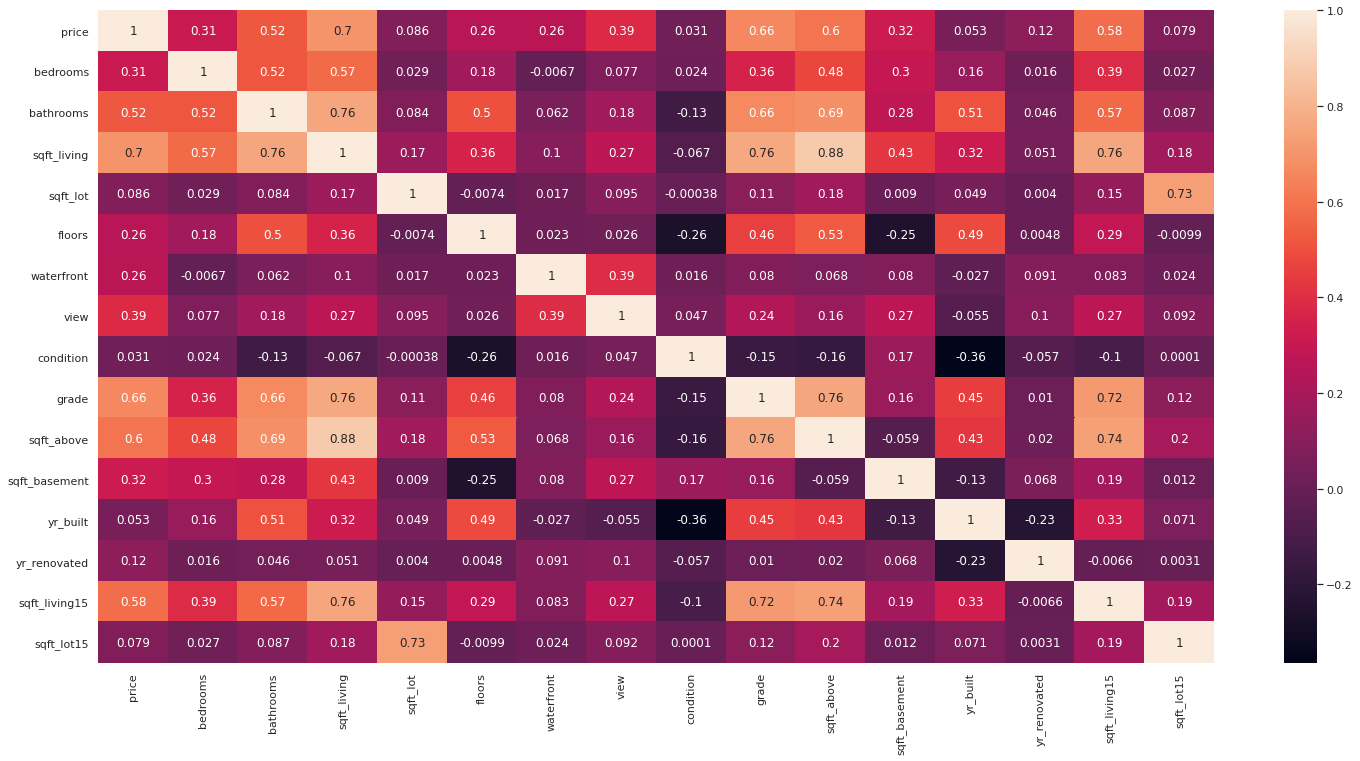

In [53]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

## 4.0 Data Preparation

In order to proceed with the analysis, we need to first handle the outliers, once we're gonna infer prices from features using a linear model. 

### 4.1 Handling outliers using IQR.

**IQR or interquartile range** 
is a measurement of variability built on dividing the dataset into different counties. Counties are broken down in Q1, Q2, and Q3, where Q1 is the middle value of the first half of the dataset. Q2 is the median value, and Q3 is the middle value of the second half of the dataset.


After computing IQR, we calculate **the lower limit and upper limit** and then simply discard all the values that are less or above the limit and replace them with lower and upper limit consequently.¶

In [69]:
df3 = df2.copy()

#### Price

In [70]:
Q1 = df3['price'].quantile(0.25)
Q3 = df3['price'].quantile(0.75)
print('Q1:',Q1)
print('Q3: ',Q3)

IQR = Q3-Q1
print('IQR: ',IQR)

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print('Lower limit: ',lower_limit)
print('Upper limit: ',upper_limit)

df3['price'] = np.where(df3['price']>upper_limit,upper_limit,df3['price'])
df3['price'] = np.where(df3['price']<lower_limit,lower_limit,df3['price'])

Q1: 320000.0
Q3:  640000.0
IQR:  320000.0
Lower limit:  -160000.0
Upper limit:  1120000.0


/home/jvbf/anaconda3/envs/house-sales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


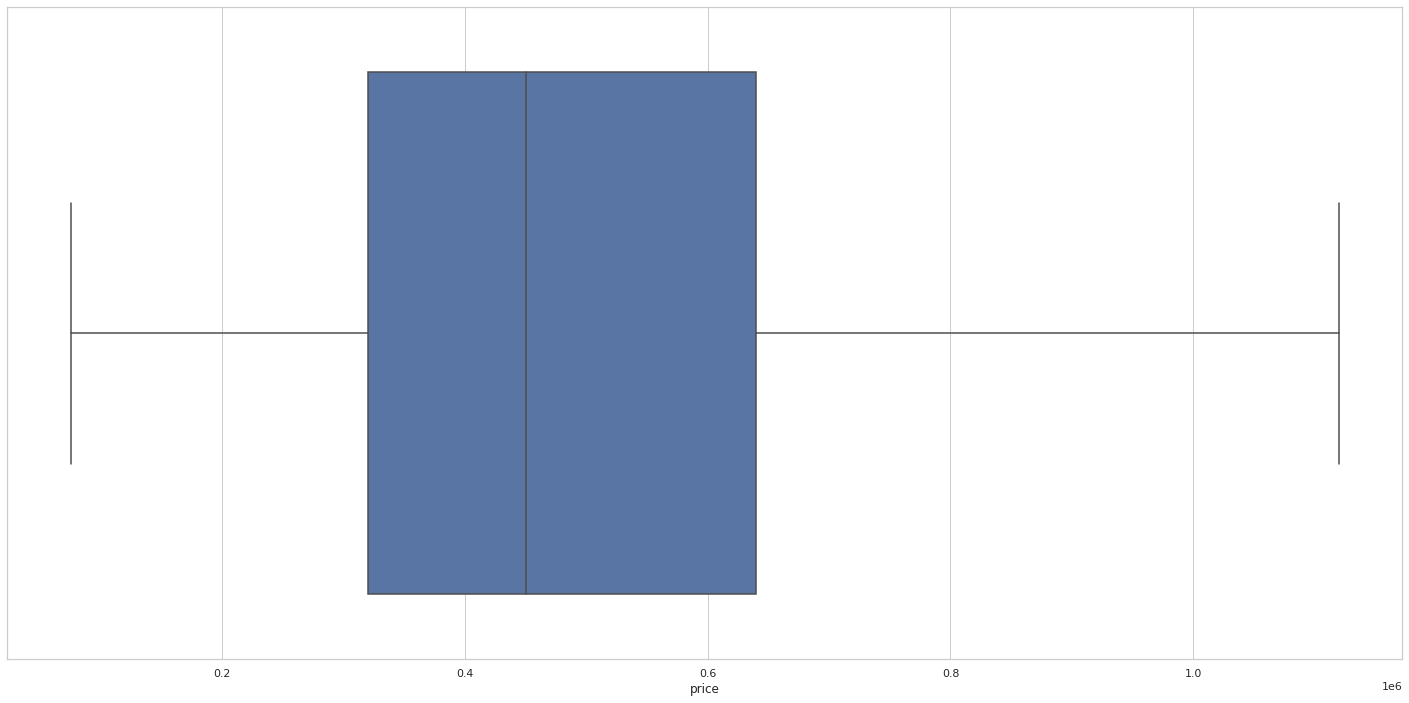

In [71]:
sns.boxplot(df3['price']);

Last, we're going to use de natural logarithm of price, due to interpretation improvements

In [72]:
df3['price'] = np.log1p(df3['price'])

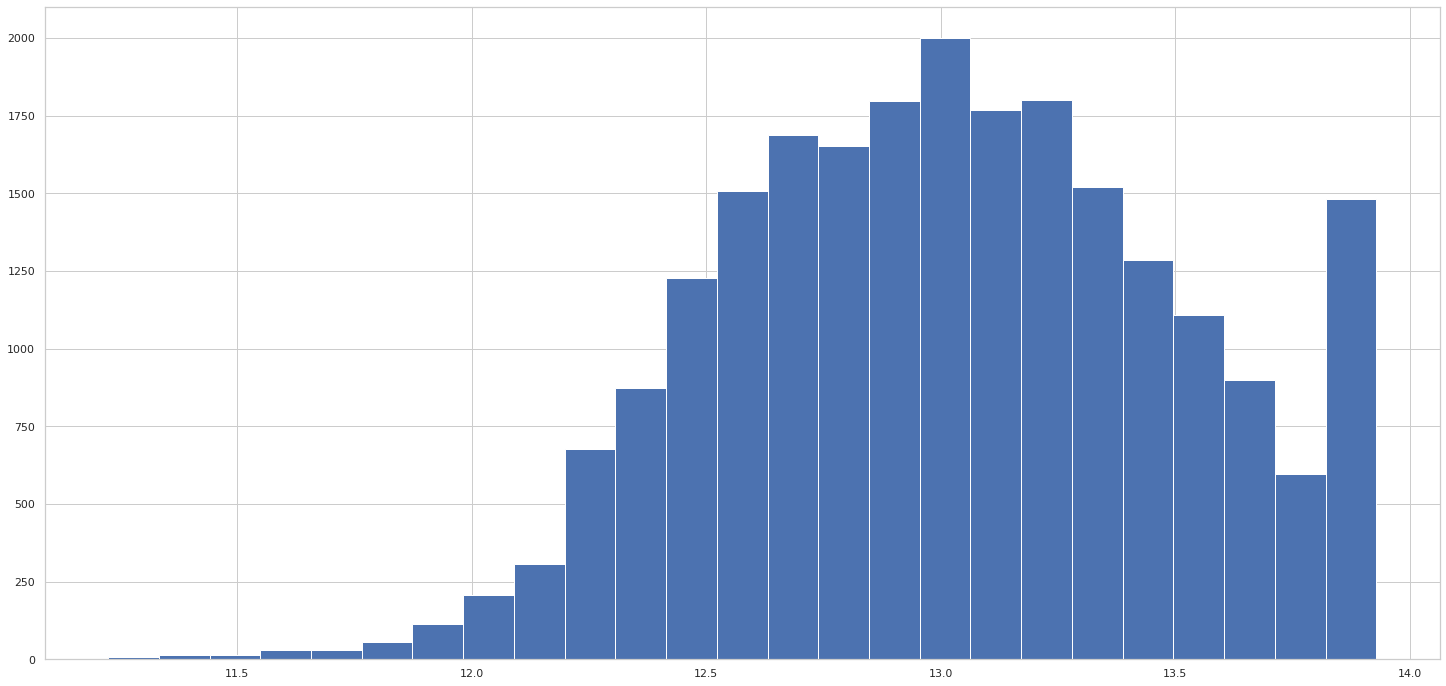

In [73]:
df3['price'].hist(bins = 25);

### 4.2 Encoding

In [74]:
df3['waterfront'] = df3['waterfront'].apply(lambda x: 1 if x == 'Yes' else 0)

## 5.0 Modeling

In [75]:
df4 = df3.copy()

In [98]:
X = df4.drop(['id','sqft_living_change', 'city','house_ratio', 'sqft_above', 'date','yr_built','sqft_basement', 'yr_renovated', 'price', 'sqft_lot','zipcode', 'sqft_lot15', 'month', 'year', 'house_type'], axis = 1)
y = df4['price']

In [99]:
inpc=sm.add_constant(X)
ols=sm.OLS(y,inpc)
ols_mod=ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     5168.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:55:45   Log-Likelihood:                -1426.2
No. Observations:               22656   AIC:                             2876.
Df Residuals:                   22644   BIC:                             2973.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -73.3326      1.637    -44.810      0.000     -76.540     -70.125
bedrooms          0.0046      0.002      1.956      0.050   -8.53e-06       0.009
bathrooms         0.0250      0.004      6.564      0.000       0.018       0.032
sqft_living       0.0001   4.07e-06     29.531      0.000       0.000       0.000
floors            0.0394      0.004     10.047      0.000       0.032       0.047
waterfront        0.1163      0.022      5.263      0.000       0.073       0.160
view              0.0642      0.003     24.757      0.000       0.059       0.069
condition         0.0911      0.003     32.931      0.000       0.086       0.097
grade             0.1233      0.003     47.529      0.000       0.118       0.128
lat               1.3738      0.012    113.923      0.000       1.350       1.397
long             -0.1569      0.013    -11.686      0.000      -0.183      -0.131
sqft_living15     0.0001   4.23e-06     24.212      0.000    9.41e-05       0.000
==============================================================================
Omnibus:                      329.934   Durbin-Watson:                   1.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              629.115
Skew:                          -0.024   Prob(JB):                    2.45e-137
Kurtosis:                       3.815   Cond. No.                     2.95e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

PS: The high condition number is due to scalling, once statsmodels reports the condition number of the design matrix and not of a standardized design matrix. the large condition number in this case results from scaling rather than from multicollinearity.

In [96]:
X = df4.drop(['id', 'city','bathrooms','sqft_living_change','bedrooms','sqft_above', 'date','yr_built','sqft_basement', 'yr_renovated', 'price', 'sqft_lot','zipcode', 'sqft_lot15', 'month', 'year', 'house_type'], axis = 1)
y = df4['price']

In [97]:
inpc=sm.add_constant(X)
ols=sm.OLS(y,inpc)
ols_mod=ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     5680.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:54:54   Log-Likelihood:                -1433.9
No. Observations:               22656   AIC:                             2890.
Df Residuals:                   22645   BIC:                             2978.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -73.1226      1.635    -44.719      0.000     -76.328     -69.918
sqft_living       0.0001    3.3e-06     41.263      0.000       0.000       0.000
floors            0.0415      0.004     10.781      0.000       0.034       0.049
waterfront        0.1074      0.022      4.862      0.000       0.064       0.151
view              0.0629      0.003     24.263      0.000       0.058       0.068
condition         0.0920      0.003     33.252      0.000       0.087       0.097
grade             0.1218      0.003     47.037      0.000       0.117       0.127
lat               1.3686      0.012    113.611      0.000       1.345       1.392
long             -0.1572      0.013    -11.713      0.000      -0.184      -0.131
sqft_living15     0.0001   4.23e-06     24.039      0.000    9.33e-05       0.000
house_ratio       0.0578      0.009      6.187      0.000       0.039       0.076
==============================================================================
Omnibus:                      355.247   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              690.105
Skew:                          -0.040   Prob(JB):                    1.40e-150
Kurtosis:                       3.851   Cond. No.                     2.95e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6.0 Business Interpretation and Insights

In [112]:
house_ratio_inc = (np.exp(0.0578) -1)*100
floors_inc = (np.exp(0.0415) -1)*100
waterfront_inc = (np.exp(0.1074) -1)*100 
sqft_living_inc = (np.exp(0.0001) -1)*100 
view_inc = (np.exp(0.0629) -1)*100 
condition_inc = (np.exp(0.0920) -1)*100
bath_inc = (np.exp(0.0250) -1)*100
grade_inc = (np.exp(0.1218) -1)*100

In [121]:
d = {'change %': [house_ratio_inc.round(2), floors_inc.round(2), waterfront_inc.round(2), sqft_living_inc.round(2), 
              view_inc.round(2), condition_inc.round(2), bath_inc.round(2), grade_inc.round(2)], 
     
     'Feature': ['house ratio', 'floors', 'waterfront', 'sqft living', 'view', 'condition', 'bath', 'grade' ]}
h = pd.DataFrame(data=d).sort_values('change %', ascending = False)
h

,change %,Feature
7,12.95,grade
2,11.34,waterfront
5,9.64,condition
4,6.49,view
0,5.95,house ratio
1,4.24,floors
6,2.53,bath
3,0.01,sqft living


- Increasing by 1 point the bath/bedroom ratio, translates in about 5.95% increase in price 

The CEO should consider first, buying houses with 1 bathroom and 1 bedroom, and then build a bathroom. Doing so, the bath/bed ration would increase by one, and the price would rise 5.95% on average in the market

In [125]:
sugestion = df1[(df1['bathrooms'] == 1) & (df1['bedrooms'] == 1)]

In [136]:
sugestion['price'].mean()

315002.3521126761

In [135]:
sugestion.describe().T

,count,mean,std,min,25%,50%,75%,max
id,142.0,4.131669e+09,2.844551e+09,5.900020e+07,1.775500e+09,3.278603e+09,6.634276e+09,9.834201e+09
price,142.0,3.150024e+05,1.358558e+05,8.995000e+04,2.161250e+05,3.059750e+05,3.950000e+05,7.130000e+05
bedrooms,142.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
bathrooms,142.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
sqft_living,142.0,8.232394e+02,2.998145e+02,3.900000e+02,6.425000e+02,7.300000e+02,9.275000e+02,2.880000e+03
sqft_lot,142.0,1.639680e+04,5.076562e+04,8.330000e+02,4.000000e+03,5.660500e+03,8.261000e+03,5.336100e+05
floors,142.0,1.063380e+00,1.869801e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
waterfront,142.0,2.112676e-02,1.443159e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,142.0,2.394366e-01,8.415586e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,142.0,3.267606e+00,7.429622e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


There is 142 houses with one bedroom and one bathroom, with an average price of 315002.35 dollars. 

Building a bathroom would increase the price of these houses in about 19 thousand dollars on average. 

It is important to notice that, these houses are low-cost, and a low-cost bathroom costs around 2 to 4 thousand dollars to build remodeling existing space. 

<AxesSubplot:xlabel='bathrooms', ylabel='grade'>

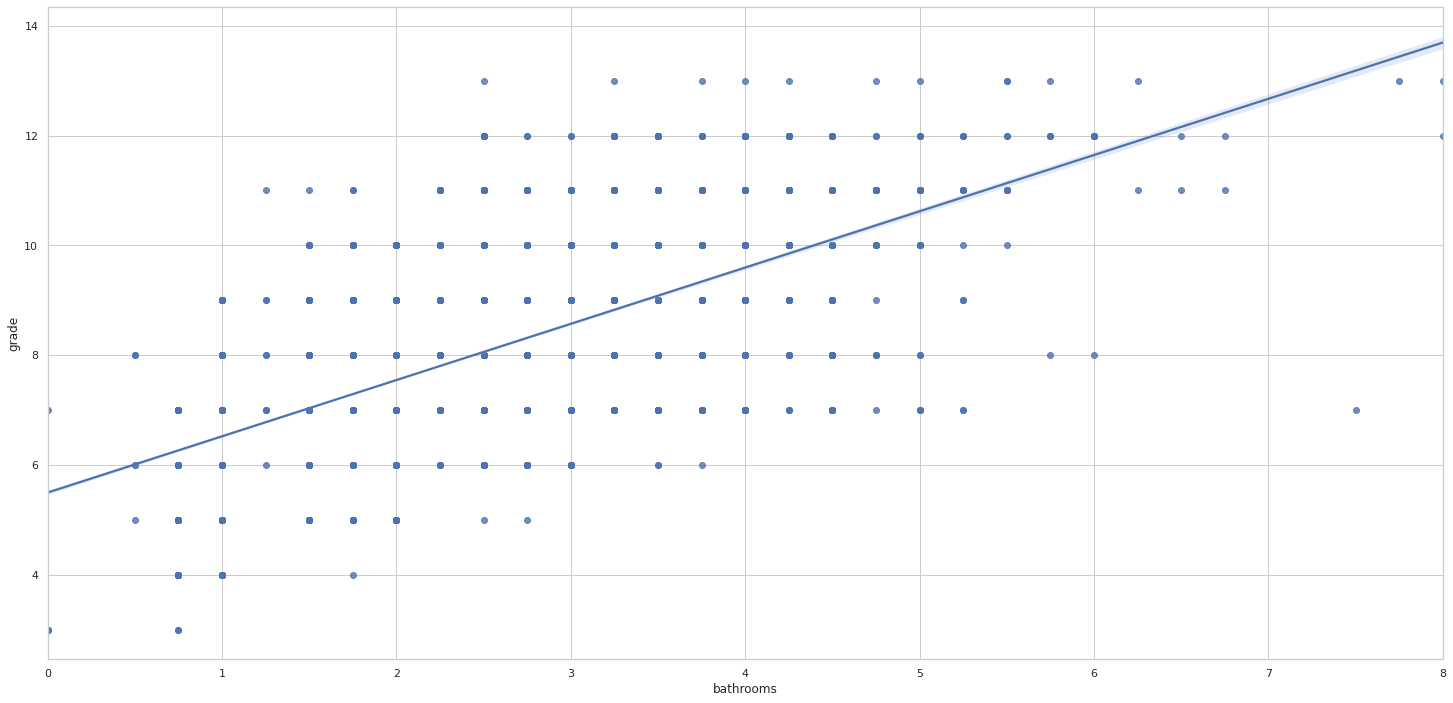

In [146]:
sns.regplot(x = 'bathrooms', y = 'grade', data = df1)

Also, increasing the bath/bedroom ratio, also increases the grade of the house, as we saw on the exploratory data analysis, and increasing the grade of the house should rise the selling price even more

## Next Steps: Create a model to explore the exact price of changing existing houses 